In [1]:
import pandas as pd
import spacy

import networkx as nx
from networkx.algorithms import community
from networkx.algorithms.community import k_clique_communities

import re
import itertools
import langid
import random

import matplotlib.pyplot as plt



In [2]:
df = pd.read_csv('..\\data\\ocred\\files_df.csv', index_col = 0)
spacy.prefer_gpu()
nlp = spacy.load("nl_core_news_lg")
nlp_ministries = spacy.load("..\\data\\spacy labeled\\output\\model-last")

c:\Users\justin\AppData\Local\Programs\Python\Python39\lib\site-packages\spacy\util.py:837: UserWarning: [W095] Model 'nl_pipeline' (0.0.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.3.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


## setup
The co-occurrence network was made with the results of the NER. The network consists of a number of nodes and edges. The nodes, in this case, are the found named entities. If these entities occur in the close together in a text it would count as the nodes sharing an edge. To find the nodes and edges for the network, first a number of random pages are selected. The default is 1000. These pages are then put through the spaCy NER to retreive all named entities. Only entities that were clasified as location, person, and organization were concidered. Then the entities that only occur once or in one document are removed. Some english text exists in the documents so if english texts makes it into the named entities, they are removed. This process results in a python dictionary with document pages as keys and a list of entities that occur in those pages as values. Form this, a list of edges for the network can be generated. The network is also weighted, with the weights being the number of times two nodes co-occured in a page.

## results

One limiting factor is that there is quite some noise from NER. 

In [3]:
def getMatches(doc, entTypes = None):

    # list of entities to include
    if entTypes:
        wantedTypes = entTypes
    else:
        wantedTypes = ['FAC','GPE','LOC', 'ORG', 'PERSON']

    bannedWords = ['sent', 'cc', 'for', 'te', 'we', 'to']

    wantedEnts = []

    # for all entities, check if to include and clean up the string
    for ent in doc.ents:
        if ent.label_ in wantedTypes:
            text = str(ent.text)
            text = text.lower()
            text = re.sub(r'\n', ' ', text)
            text = text.strip()

            if text.endswith('2e'):
                continue
            if text in bannedWords:
                continue
            if len(text) == 1:
                continue
                

            wantedEnts.append(text)    
    
    # retrun list of entities 
    return wantedEnts

In [4]:
# remove all entities that only occur in one document
def goodEnts(entities):
    ents = {}

    # get a dict of entities as keys and a list of documents in which the entity occurs as values
    for document in entities:
        for ent in entities[document]:
            if ent in ents:
                ents[ent].append(document)
            else:
                ents[ent] = [document]

    entsToDelete = []

    # find and deletes entities that only occur in one document
    for ent in ents:
        language = langid.classify(ent)
        if len(ents[ent]) <= 1:
            entsToDelete.append(ent)
        
        # checks if the ent is english
        if language[0] =='en' and language[1] < 0:
            entsToDelete.append(ent)

    for ent in set(entsToDelete):
        del ents[ent]

    documents = {}

    # revert back to original format
    # documents as keys, entities in said document as values
    for ent in ents:
        for doc in ents[ent]:
            if doc in documents:
                documents[doc].append(ent)
            else:
                documents[doc] = [ent]
    
    return documents
    

In [5]:
def getEntities(text, name, entTypes):
    try:
        text = re.sub('\n+', '\n', text)
        text = re.sub(' +', ' ', text)

        if langid.classify(text)[0] != 'nl':
            return {name:[]}

        NERdoc = nlp(text)
        NERmatches = getMatches(NERdoc, entTypes)
        
        # MinDoc = nlp_ministries(text)
        # MinMatches = getMatches(MinDoc)
    except:
        return {name:[]}

    return {name: list(set(NERmatches))}

In [6]:
def orderCheck(x, y):
    ordered = [x, y]
    ordered.sort()
    return ordered[0], ordered[1]

We want a dictionary with named documents as keys and and lists of entities that occur in it as values

In [7]:
def getEdges(entities):
    entitiesDict = {}

    for d in entities:
        key = list(d.keys())[0]
        entitiesDict[key] = d[key]

    entitiesDict = goodEnts(entitiesDict)

    edges = {}

    for document in entitiesDict:
        if len(entitiesDict[document]) <= 1:
            continue
        
        for edge in itertools.combinations(entitiesDict[document], 2):
            node1, node2 = orderCheck(edge[0], edge[1])
            key = node1 + '\t' + node2 
            if key in edges:
                edges[key].append(document)
            else:
                edges[key] = [document]

    return edges

In [8]:
def makeGraph(df, n = 100, method = 'random', entTypes = None):
    G = nx.Graph()

    if method == 'random':
        df = df.sample(n, random_state=1)

    elif method == 'wob':
        files = list(df.name.unique())
        choice = random.choice(files)
        request = choice.split('_')[0]
        df = df[df.name.str.contains(request)]	

    df = df.apply(lambda row: getEntities(row['text'], row['full_name'], entTypes), axis=1)

    edges = getEdges(df)
    print(len(edges))
    for edge in edges:
        nodes = edge.split('\t')
        # G.add_edge(nodes[0], nodes[1])
        G.add_edge(nodes[0], nodes[1], weight = len(edges[edge]))

    if len(list(nx.connected_components(G))) > 1:
        x = [len(c) for c in list(nx.connected_components(G))]
        x.sort(reverse=True)
        limit = x[1]
        del x
        for component in list(nx.connected_components(G)):
            if len(component)<=limit:
                for node in component:
                    G.remove_node(node)

    
    print(f'Components: {nx.number_connected_components(G)}\nNumber of edges: {G.number_of_edges()}\nNumber of nodes: {G.number_of_nodes()}')
    return G



# fig = plt.figure(1, figsize=(30, 30), dpi=60)
# nx.draw(G, node_size = 50)

In [9]:
def drawWeightedGraph(G):
    pos = nx.spring_layout(G, seed=0)
    fig = plt.figure(1, figsize=(25, 25), dpi=60)
    nx.draw_networkx(G, pos, with_labels=False, node_size = 50)

    for edge in G.edges(data='weight'):
        nx.draw_networkx_edges(G, pos, edgelist=[edge], width=edge[2], label=None )


In [10]:
def mostConnectedNodes(G, n = 10):
    nodeNeighbors = [(node, len(list(G.neighbors(node)))) for node in G.nodes]
    sortedNodes = sorted(nodeNeighbors, key=lambda tup: tup[1])
    print('Most connections')
    for node in sortedNodes[-n:]:
        print(node)


In [11]:
def mostCooccurences(G, n = 10):

    weightedEdges =  G.edges(data='weight')

    sortedEdges = sorted(weightedEdges, key=lambda tup: tup[2])
    print('Most co-occurrences')
    for edge in sortedEdges[-n:]:
        print(edge)


In [12]:
def calculateCentrality(G, n = 10):
    centrality = nx.degree_centrality(G)
    centrality = [(x, centrality[x]) for x in centrality]
    centrality = sorted(centrality, key=lambda tup: tup[1])
    print('centrality of nodes')
    for node in centrality[-n:]:
        print(node)


In [13]:
def calculateBetweenness(G, n = 10):
    betweenness = nx.betweenness_centrality(G)
    betweenness = [(x, betweenness[x]) for x in betweenness]
    betweenness = sorted(betweenness, key=lambda tup: tup[1])
    print('betweenness of nodes')
    for node in betweenness[-n:]:
        print(node)



In [14]:
def calculateCloseness(G, n = 10):
    closeness = nx.closeness_centrality(G)
    closeness = [(x, closeness[x]) for x in closeness]
    closeness = sorted(closeness, key=lambda tup: tup[1])
    print('closeness of nodes')
    for node in closeness[-n:]:
        print(node)


In [53]:
def findRequstByPagecount(n):
    names = list(df.name.values)
    names = [x.split('_')[0] for x in names]
    names = list(set(names))

    closest = 1000000
    code = ''

    for name in names:
        nPages = df[df.name.str.contains(name)].shape[0]

        if abs(n - nPages) < closest:
            closest = abs(n - nPages)
            code = name
    return df[df.name.str.contains(code)]


In [18]:
def calcMeasures(G):
    mostConnectedNodes(G)
    mostCooccurences(G)
    return list(k_clique_communities(G, 4))

## Network split in person, location, and organisation

In [47]:
df2 = findRequstByPagecount(500)
GPerons = makeGraph(df2, method='df', entTypes = ['PERSON'])
print('People')
personCliques = calcMeasures(GPerons)

GOrg = makeGraph(df2, method='df', entTypes = ['ORG'])
print('Organizations')
OrgCliques = calcMeasures(GOrg)

GLocation = makeGraph(df2, method='df', entTypes = ['FAC','GPE','LOC'])
print('locations')
locationCliques = calcMeasures(GLocation)

317
Components: 1
Number of edges: 317
Number of nodes: 76
People
Most connections
('h.p.', 16)
('corona', 17)
('birgitta', 18)
('mark', 22)
('m. van der', 23)
('jaap van dissel', 24)
('coronavirus', 25)
('angelique', 25)
('scheidel', 34)
('ciska', 52)
Most co-occurrences
('h.p.', 'herbert', 5)
('corona', 'ciska', 6)
('coronavirus', 'jaap van dissel', 6)
('uum', 'theo', 6)
('ciska', 'ciska scheidel', 7)
('scheidel', 'angelique', 7)
('ciska', 'mon', 8)
('m. van der', 'mark', 11)
('ciska', 'angelique', 16)
('ciska', 'scheidel', 35)
4035
Components: 1
Number of edges: 4029
Number of nodes: 325
Organizations
Most connections
('@minvws.nl>', 92)
('dcc', 99)
('epsco', 99)
('ministerie van volksgezondheid, welzijn en sport |', 106)
('who', 110)
('covid-19', 125)
('ke', 143)
('www.blackberry.com', 149)
('pm', 184)
('rivm', 205)
Most co-occurrences
('bz', 'rivm', 16)
('rivm', 'who', 16)
('rivm', 'btcb', 16)
('pm', 'driece', 17)
('covid-19', 'rivm', 17)
('ke', 'pm', 18)
('www.blackberry.com', 'd

## full network

In [48]:
G = makeGraph(df2, method='df')

print('Full')
personCliques = calcMeasures(GPerons)

11242
Components: 1
Number of edges: 11242
Number of nodes: 510
Full
Most connections
('h.p.', 16)
('corona', 17)
('birgitta', 18)
('mark', 22)
('m. van der', 23)
('jaap van dissel', 24)
('coronavirus', 25)
('angelique', 25)
('scheidel', 34)
('ciska', 52)
Most co-occurrences
('h.p.', 'herbert', 5)
('corona', 'ciska', 6)
('coronavirus', 'jaap van dissel', 6)
('uum', 'theo', 6)
('ciska', 'ciska scheidel', 7)
('scheidel', 'angelique', 7)
('ciska', 'mon', 8)
('m. van der', 'mark', 11)
('ciska', 'angelique', 16)
('ciska', 'scheidel', 35)


## Visualisation of persons network
This is the smallest of the 3 so its easier to see things

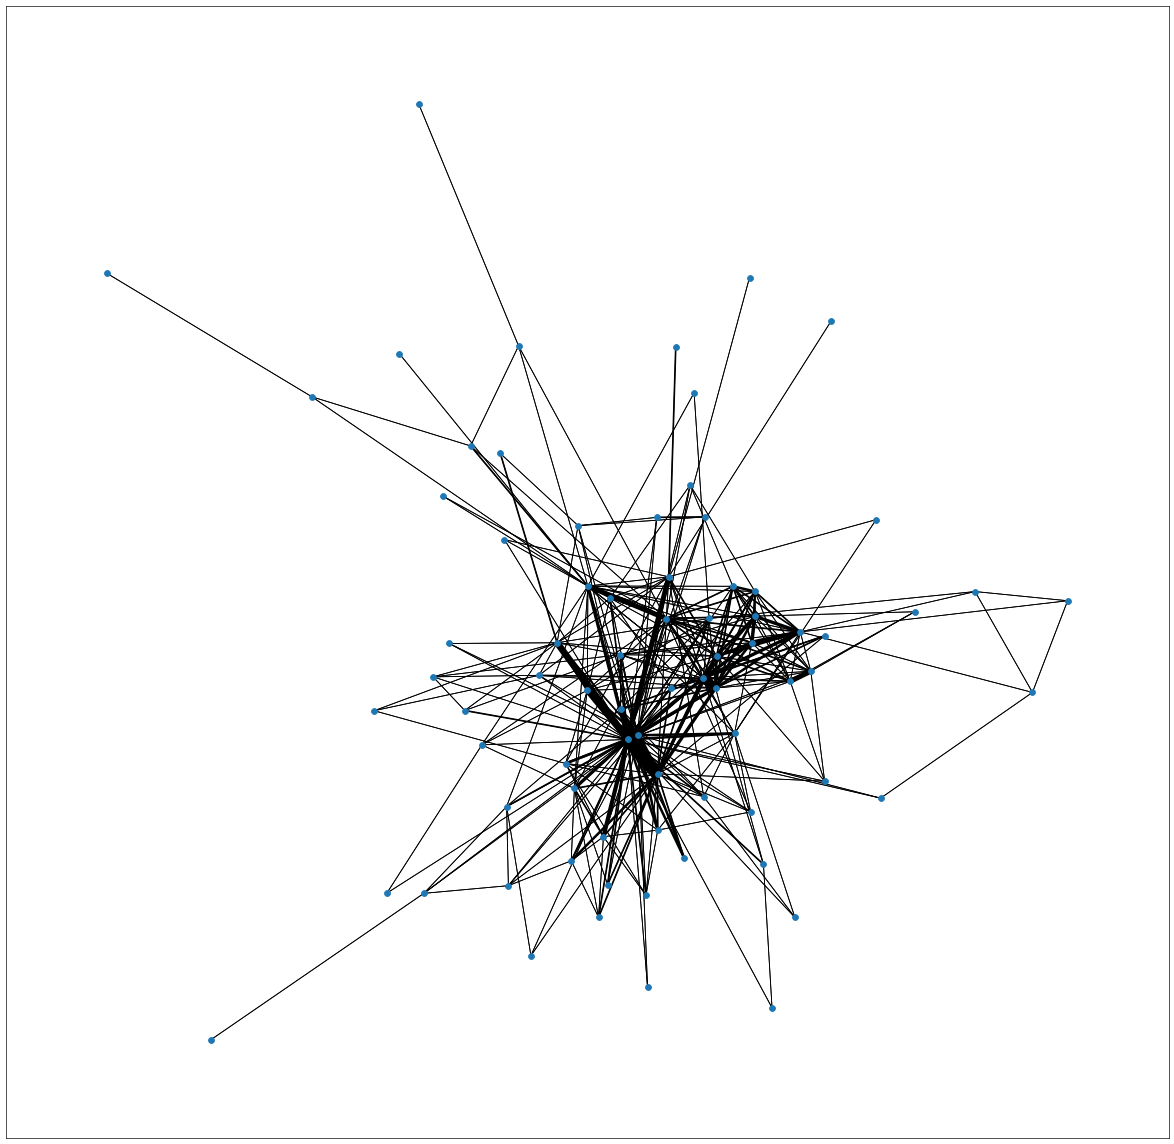

In [69]:
drawWeightedGraph(GPerons)

## K cliques for location sub graph

In [73]:
list(k_clique_communities(GLocation, 3))

[frozenset({'thur', 'wuhan', 'wuhan coronavirus'}),
 frozenset({'@mininv.nl',
            '@minvws.nl]',
            '@rivm.nl',
            '@rivm.nl]',
            'am',
            'amsterdam',
            'aruba',
            'bangkok',
            'bd/ncc/ecr',
            'beijing',
            'belgië',
            'berg',
            'berlijn',
            'bern',
            'bogor',
            'boussen',
            'brabant',
            'brussel',
            'calamiteitenhospitaal',
            'cambodja',
            'cariben',
            'caribisch nederland',
            'china',
            'corona',
            'coronavirus',
            'curacao',
            'dcc-vws',
            'den haag',
            'denemarken',
            'diemen',
            'dienstpostbus',
            'dienstpostbus dcc-vws <dcc@minvws.nl>',
            'drivm.nl>',
            'duitsland',
            'e@',
            'ecdc',
            'estland',
            'eu',
            'euro